In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch

import sys
sys.path.append('../')
from utils.limitcycle import make_limitcycle_dataset
from PhaseReductionNet import Encoder, Decoder, LatentSteper

plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 30 

def to_polar(x):
    theta = torch.atan2(x[:, 1], x[:, 0])
    return theta

In [2]:
device = 'cuda'
enc = Encoder(input_dim=2,output_dim=3,hidden_dim = 100)
step = LatentSteper(zd = 1)
dec = Decoder(input_dim=3,output_dim=2,hidden_dim = 100)

model = 'SL'
result_dir = f'../out/SL/'

enc.load_state_dict(torch.load(os.path.join(result_dir,'enc.pth')))
step.load_state_dict(torch.load(os.path.join(result_dir,'step.pth')))
dec.load_state_dict(torch.load(os.path.join(result_dir,'dec.pth')))

enc.to(device)
step.to(device)
dec.to(device)

enc.eval()
step.eval()
dec.eval()
print(step.state_dict())
w = step.state_dict()['theta'].item()
print(w)

X0 = np.load(f'../data/limit_cycle_{model}.npy')
Z0 = np.load(f'../data/phase_response_function_{model}.npy')
print(X0.shape)
mean = np.mean(X0,axis=0)
std = np.std(X0,axis=0)
print(mean,std)

OrderedDict([('theta', tensor(-0.2651, device='cuda:0')), ('lam', tensor([0.9312], device='cuda:0'))])
-0.2651059925556183
(1185, 2)
[7.97970044e-05 3.25466738e-05] [0.70855789 0.70851176]


In [3]:
zs = []
ys = []
ps = []
for i in range(0,len(X0),1):
    x = [[(X0[i,0]-mean[0])/std[0],(X0[i,1]-mean[1])/std[1]]]
    x = torch.Tensor(x).to(device,dtype = torch.float)
    z = enc(x)
    p = to_polar(z[:,:2]).item()
    y = dec(z)
    zs.append(z.detach().to('cpu').numpy())
    ys.append(y.detach().to('cpu').numpy())
    ps.append(p)
    
zs = np.concatenate(zs)
ys = np.concatenate(ys)

_ps = []
a = np.linspace(0,2*np.pi,len(ps))
for i in range(len(ps)):
    if w > 0:
        _ps.append((ps[i]-ps[0])%(2*np.pi))
    else:
        _ps.append(2*np.pi-(ps[i]-ps[0]-0.00001)%(2*np.pi)+0.00001)

eX0 = []
#grad = []
e = 0.05
for theta in np.linspace(0,2*np.pi,500):
    z = [[np.cos(theta),np.sin(theta),0.0]]
    z = torch.Tensor(z).to(device,dtype = torch.float)
    out = dec(z)
    nz = [[np.cos(theta+e),np.sin(theta+e),0.0]]
    nz = torch.Tensor(nz).to(device,dtype = torch.float)
    nout = dec(nz)
    eX0.append(out.detach().to('cpu').numpy())
    #grad.append(nout.detach().to('cpu').numpy())
eX0 = np.concatenate(eX0)
#grad = np.concatenate(grad)




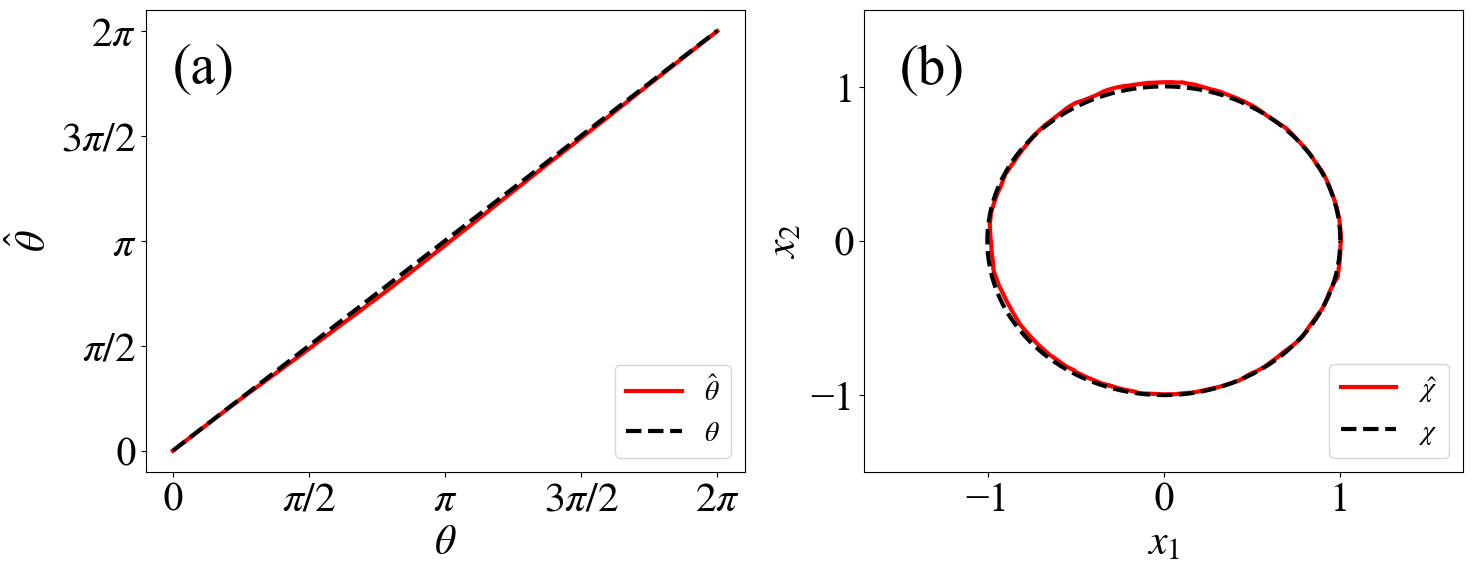

In [4]:
plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
plt.plot(a,_ps, color = 'red',label=rf'$\hat \theta$',lw=3)
plt.plot(a,a, color = 'black',linestyle='dashed',label=rf'$\theta$',lw=3)
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.yticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.text(0,5.5 ,'(a)',fontsize=40)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\hat{\theta}$')
plt.legend(loc='lower right',fontsize=20)
plt.subplot(1,2,2)

plt.plot(eX0[:,0]*std[0]+mean[0],eX0[:,1]*std[1]+mean[1], color = 'red',lw=3,label=r'$\hat \chi$')
plt.plot(X0[:,0],X0[:,1],color='black',label=r'$\chi$',lw=3,linestyle='--')
plt.text(-1.5,1.02 ,'(b)',fontsize=40)
plt.xlim(-1.7,1.7)
plt.ylim(-1.5,1.5)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc = 'lower right',fontsize=20)
#plt.savefig('../figure/SL_LC.png', bbox_inches='tight')
plt.savefig('../figure/SL_LC.pdf', bbox_inches='tight')
plt.show()

In [5]:
grad = []
for i in range(len(X0)):
    x = [[(X0[i,k]-mean[k])/std[k] for k in range(X0.shape[1])]]
    x = torch.Tensor(x).to(device,dtype = torch.float)
    x.requires_grad = True
    p = to_polar(enc(x)[:, :2])
    p.backward()
    z = enc(x)
    grad.append(x.grad.detach().to('cpu').numpy()[0])

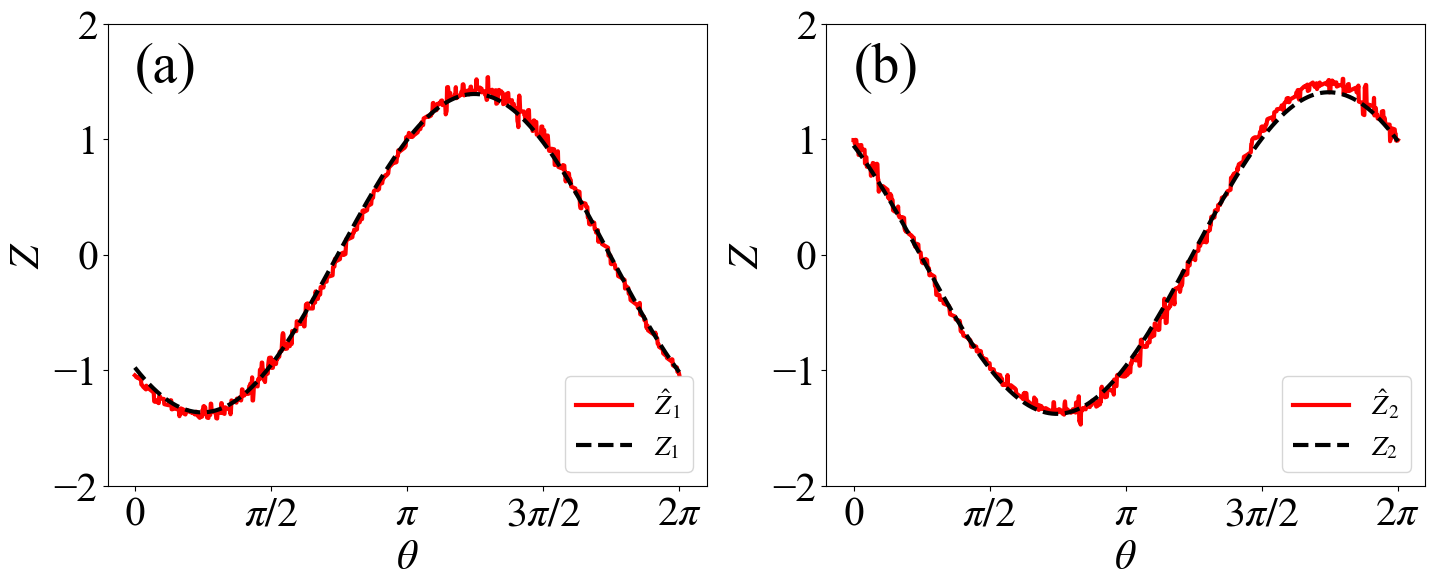

In [6]:
plt.figure(figsize=(17,6))
xx  = np.linspace(0,2*np.pi,len(X0))
for k in range(Z0.shape[1]):
    plt.subplot(1,2,k+1)
    if w>0:
        plt.plot(xx,[grad[i][k]/std[k] for i in range(len(X0))],color='red',label=rf'$\hat Z_{k+1}$',lw=3)
    else:
        plt.plot(xx,[-grad[i][k]/std[k] for i in range(len(X0))],color='red',label=rf'$\hat Z_{k+1}$',lw=3)
    if k==0:
        plt.text(0,1.5,'(a)',fontsize=40)
    if k==1:
        plt.text(0,1.5,'(b)',fontsize=40)
    plt.plot(xx,Z0[:,k],color='black',linestyle='--',label=rf'$Z_{k+1}$',lw=3)
    plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$Z$')
    plt.ylim(-2,2)
    plt.legend(loc='lower right',fontsize=20)
plt.savefig(f'../figure/SL_PSF.pdf', bbox_inches='tight')
plt.show()

-1.9194189310073853


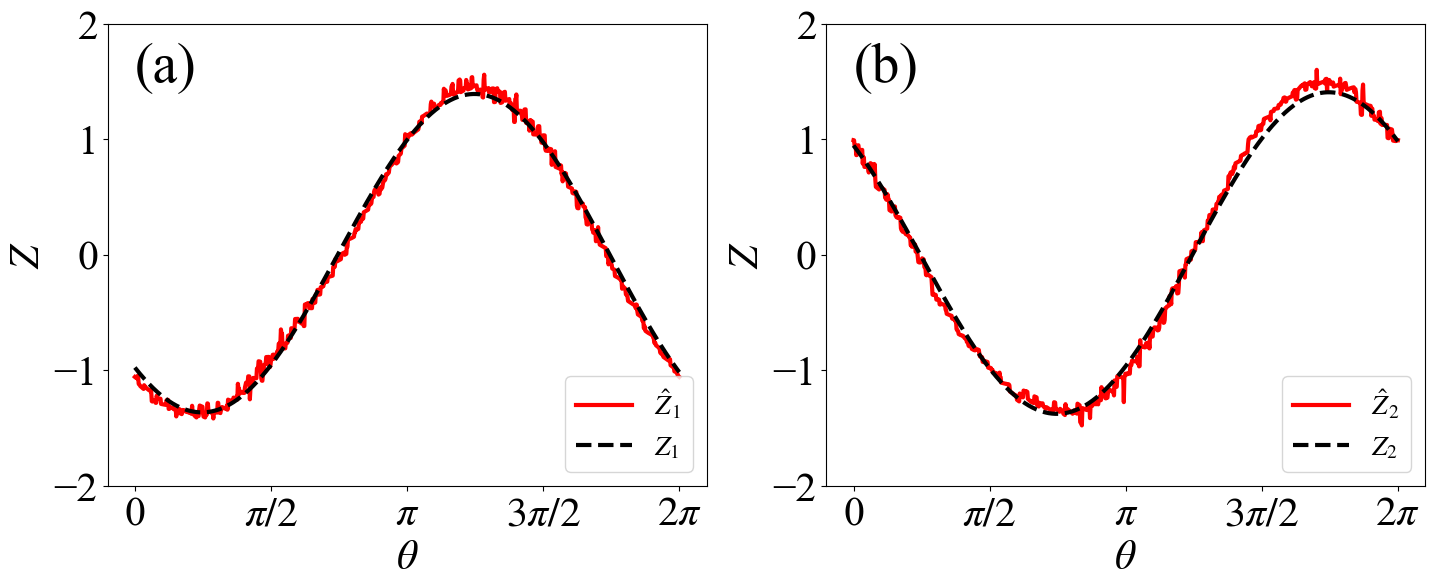

In [7]:
x = [[(X0[0,0]-mean[0])/std[0],(X0[0,1]-mean[1])/std[1]]]
x = torch.Tensor(x).to(device,dtype = torch.float)
x.requires_grad = True
z = enc(x)
p0 = to_polar(enc(x)[:,:2]).item()
print(p0)

grad = []
nnn = 1000
for theta in np.linspace(0,2*np.pi,nnn):
    if w>0:
        _x = [[np.cos(theta),np.sin(theta),0]]
    else:
        _x = [[np.cos(-theta+p0),np.sin(-theta+p0),0]]
    _x = torch.Tensor(_x).to(device,dtype = torch.float)
    _x = dec(_x).detach().to('cpu').numpy()[0]
    _x = [_x[i] for i in range(len(_x))]
    x = torch.Tensor([_x]).to(device,dtype = torch.float)
    x.requires_grad = True
    p = to_polar(enc(x)[:, :2])
    p.backward()
    z = enc(x)
    grad.append(x.grad.detach().to('cpu').numpy()[0])

plt.figure(figsize=(17,6))
xx  = np.linspace(0,2*np.pi,nnn)
for k in range(Z0.shape[1]):
    plt.subplot(1,2,k+1)
    if w>0:
        plt.plot(xx,[grad[i][k]/std[k] for i in range(nnn)],color='red',label=rf'$\hat Z_{k+1}$',lw=3)
    else:
        plt.plot(xx,[-grad[i][k]/std[k] for i in range(nnn)],color='red',label=rf'$\hat Z_{k+1}$',lw=3)
    if k==0:
        plt.text(0,1.5,'(a)',fontsize=40)
    if k==1:
        plt.text(0,1.5,'(b)',fontsize=40)
    plt.plot(np.linspace(0,2*np.pi,Z0.shape[0]),Z0[:,k],color='black',linestyle='--',label=rf'$Z_{k+1}$',lw=3)
    plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$Z$')
    plt.ylim(-2,2)
    plt.legend(loc='lower right',fontsize=20)
plt.savefig(f'../figure/SL_PSF2.pdf', bbox_inches='tight')
plt.show()

In [8]:
x = [[(X0[0,0]-mean[0])/std[0],(X0[0,1]-mean[1])/std[1]]]
x = torch.Tensor(x).to(device,dtype = torch.float)
x.requires_grad = True
z = enc(x)
p0 = to_polar(enc(x)[:,:2]).item()

n = 100
x_vec = []
y_vec = []
t_vec = []
rs = []
for _x in np.linspace(-2,2,n):
    for _y in np.linspace(-2,2,n):
        x = [[(_x-mean[0])/std[0],(_y-mean[1])/std[1]]]
        x = torch.Tensor(x).to(device,dtype = torch.float)
        x.requires_grad = True
        z = enc(x)
        p = to_polar(enc(x)[:,:2])
        x_vec.append(_x)
        y_vec.append(_y)
        p = p.item()-p0
        if p<0:
            p += 2*np.pi
        t_vec.append(p)
        rs.append(enc(x)[0,2].item())

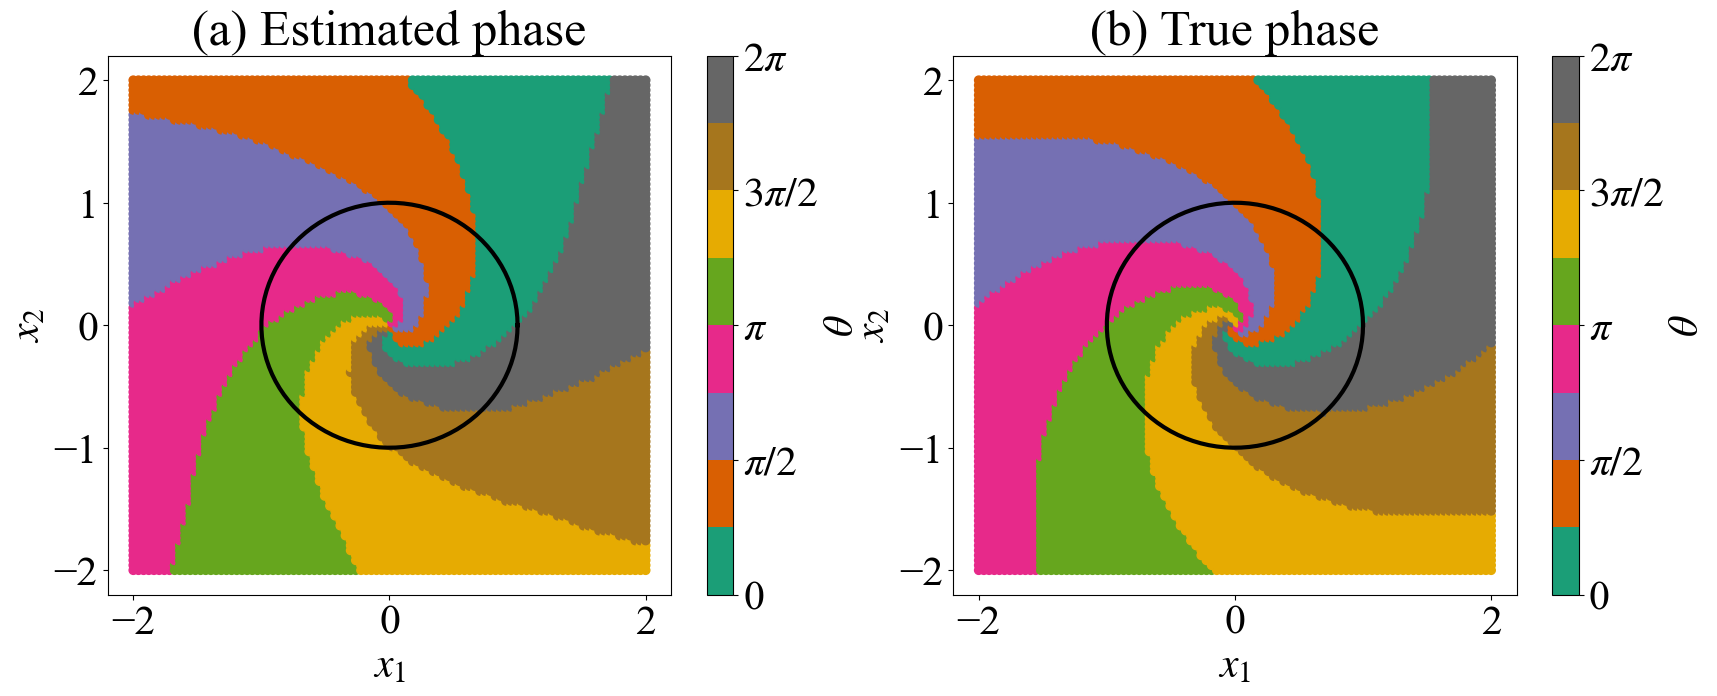

In [9]:
bs = []
for _x in np.linspace(-2,2,n):
    for _y in np.linspace(-2,2,n):
        b = to_polar(torch.Tensor([[_x,_y]]))
        b = (b-np.log(np.sqrt(_x*_x+_y*_y)))%(2*np.pi)
        bs.append(b)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1, 2, 1)
theta = np.linspace(0,2*np.pi,100)
ax.plot(np.cos(theta),np.sin(theta),color='black',lw=3)
mappable = ax.scatter(x_vec,y_vec,c=[2*np.pi-t for t in t_vec],cmap='Dark2')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('(a) Estimated phase')
pp = fig.colorbar(mappable, ax=ax, label=r'$\theta$')
pp.set_ticks(ticks=[0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               labels=[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
ax = fig.add_subplot(1, 2, 2)
theta = np.linspace(0,2*np.pi,100)
ax.plot(np.cos(theta),np.sin(theta),color='black',lw=3)
mappable = ax.scatter(x_vec,y_vec,c=bs,cmap='Dark2')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('(b) True phase')
pp = fig.colorbar(mappable, ax=ax, label=r'$\theta$')
pp.set_ticks(ticks=[0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               labels=[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.savefig(f'../figure/SL_PF.pdf', bbox_inches='tight')
plt.show()

In [10]:
dt = 0.001
num_rotation = 4
T = 2*np.pi/(2*np.pi-1)/dt/10
X0 = [[2.25,0.0],[1.5,0.0],[1.0,0.0],[1/1.5,0.0],[1/2.25,0.0]]
data = make_limitcycle_dataset(model_nm=model,
                                    X0=X0,
                                    num_rotation=num_rotation,
                                    dt=dt
                                    )

5it [00:00, 312.57it/s]


(5, 4758, 2)


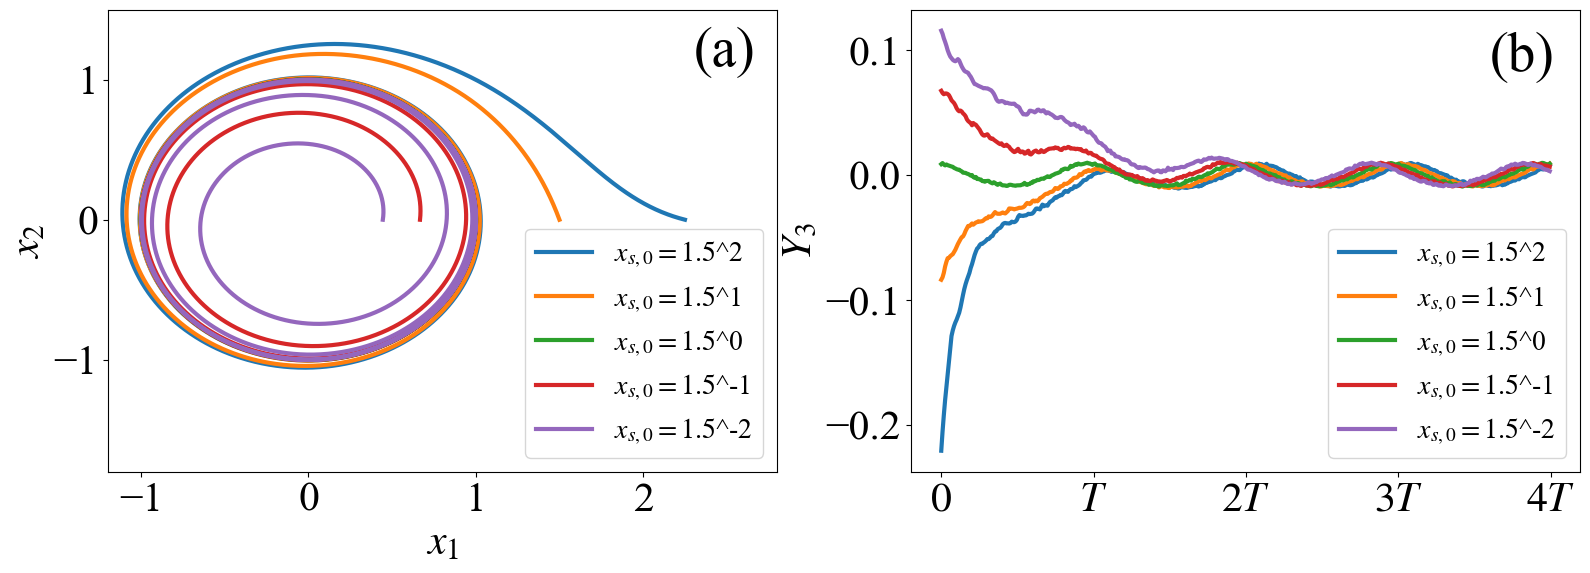

In [11]:

print(data.shape)
plt.figure(figsize=(19,6))
plt.subplot(1,2,1)
for i in range(len(data)):
    v = 2-i
    plt.plot(data[i,:,0],data[i,:,1],label=r'$x_{s,0}=1.5$^'+rf'{v}',lw=3)
plt.legend(loc='lower right',fontsize=20)
plt.xlim(-1.2,2.8)
plt.ylim(-1.8,1.5)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.text(2.3,1.1,'(a)',fontsize=40)

plt.subplot(1,2,2)

for i in range(len(data)):
    cs = []
    for d in data[i][::10]:
        x = [[(d[0]-mean[0])/std[0],(d[1]-mean[1])/std[1]]]
        x = torch.Tensor(x).to(device,dtype = torch.float)

        #x = torch.Tensor([[d[0],d[1]]]).to(device,dtype = torch.float)
        x.requires_grad = True
        z = enc(x)
        p = to_polar(enc(x)[:,:2])
        x_vec.append(_x)
        y_vec.append(_y)
        cs.append(enc(x)[0,2].item())
    v = 2-i
    plt.plot(cs,label=r'$x_{s,0}=1.5$^'+rf'{v}',lw=3)

plt.xticks([0,T,2*T,3*T,4*T],\
               [r'$0$',r'$T$',r'$2T$',r'$3T$',r'$4T$'])
plt.ylabel(r'$Y_3$')
plt.legend(loc='lower right',fontsize=20)
plt.text(3.6*T,0.083,'(b)',fontsize=40)
plt.savefig(f'../figure/SL_R.pdf', bbox_inches='tight')
plt.show()